# Mingrad demo

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs

from mingrad.scalar import Scalar
from mingrad.nn import Neuron, Layer, MLP

%matplotlib inline

In [2]:
np.random.seed(42)
random.seed(42)

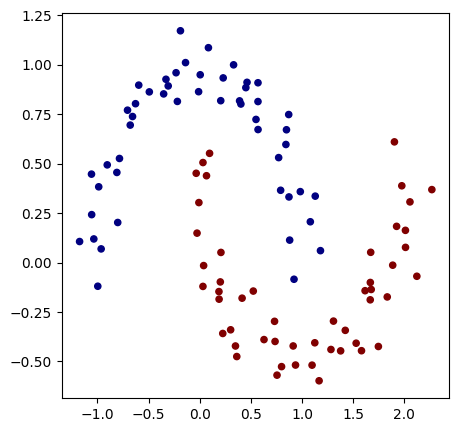

In [3]:
# Sample dataset
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet');

In [4]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [5]:
# loss function
def loss(batch_size=None):
  # inline DataLoader :)
  if batch_size is None:
    Xb, yb = X, y
  else:
    ri = np.random.permutation(X.shape[0])[:batch_size]
    Xb, yb = X[ri], y[ri]
  inputs = [list(map(Scalar, xrow)) for xrow in Xb]
    
  # forward the model to get scores
  scores = list(map(model, inputs))
    
  # svm "max-margin" loss
  losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
  data_loss = sum(losses) * (1.0 / len(losses))
  # L2 regularization
  alpha = 1e-4
  reg_loss = alpha * sum((p*p for p in model.parameters()))
  total_loss = data_loss + reg_loss
    
  # also get accuracy
  accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
  return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Scalar(data=0.7157075494482541, grad=0) 0.72


In [6]:
# optimization
for k in range(100):
  # forward
  total_loss, acc = loss()
  
  # backward
  model.zero_grad()
  total_loss.backward()
  
  # update (sgd)
  learning_rate = 1.0 - 0.9*k/100
  for p in model.parameters():
    p.data -= learning_rate * p.grad
  
  if k % 1 == 0:
    print(f"step {k+1} loss {total_loss.data}, accuracy {acc*100}%")

step 1 loss 0.7157075494482541, accuracy 72.0%
step 2 loss 1.644142932285452, accuracy 50.0%
step 3 loss 1.4234991381329356, accuracy 60.0%
step 4 loss 0.5172470301127351, accuracy 81.0%
step 5 loss 0.7647260674692989, accuracy 81.0%
step 6 loss 0.3891429188881378, accuracy 84.0%
step 7 loss 0.30180851162239963, accuracy 86.0%
step 8 loss 0.2494684092118604, accuracy 89.0%
step 9 loss 0.2498662572987315, accuracy 90.0%
step 10 loss 0.2681148927035832, accuracy 90.0%
step 11 loss 0.3188973561844591, accuracy 89.0%
step 12 loss 0.2363309740010142, accuracy 91.0%
step 13 loss 0.26660523111276424, accuracy 90.0%
step 14 loss 0.1530015069614059, accuracy 93.0%
step 15 loss 0.12256852436374632, accuracy 96.0%
step 16 loss 0.1334787626652809, accuracy 94.0%
step 17 loss 0.12385470400278314, accuracy 97.0%
step 18 loss 0.15423206113281382, accuracy 94.0%
step 19 loss 0.2269484249395796, accuracy 95.0%
step 20 loss 0.18216225667622646, accuracy 94.0%
step 21 loss 0.1119435762390744, accuracy 97

(-1.5978882018302847, 2.1521117981697153)

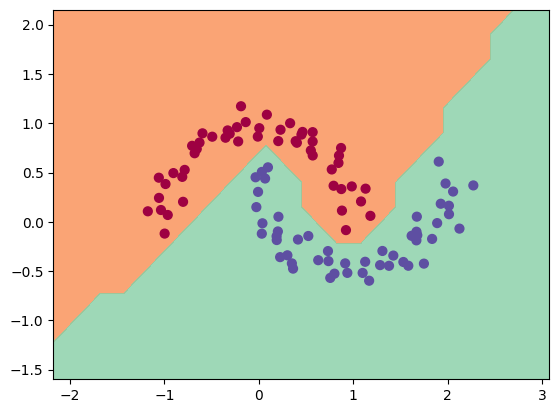

In [7]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Scalar, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())